# NFL Predictive Model


In [48]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [49]:
seasons = seasons = [str(season) for season in range(2015, 2025)]
# load data
nfl_df = pd.read_csv(f'../data/nfl_data_{seasons[0]}-{seasons[-1]}.csv')

# explore data
with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(nfl_df)

,Season,Week,Team,Date,Win,Home,Opp,Team_Pts,Opp_Pts,Spread,Total
0,2015,1,Cardinals,13-Sep,1,1,Saints,31,19,-2.0,48.5
1,2015,2,Cardinals,20-Sep,1,0,Bears,48,23,-2.0,46.0
2,2015,3,Cardinals,27-Sep,1,1,49ers,47,7,-6.5,45.0
3,2015,5,Cardinals,11-Oct,1,0,Lions,42,17,-3.0,45.5
4,2015,6,Cardinals,18-Oct,0,0,Steelers,13,25,-3.5,45.0
...,...,...,...,...,...,...,...,...,...,...,...
5193,2024,13,Commanders,01-Dec,1,1,Titans,42,19,-6.0,44.5
5194,2024,15,Commanders,15-Dec,1,0,Saints,20,19,-7.5,43.5
5195,2024,16,Commanders,22-Dec,1,1,Eagles,36,33,4.0,46.5
5196,2024,17,Commanders,29-Dec,1,1,Falcons,30,24,-3.5,46.5


In [50]:
# Add Columns
# True Total
nfl_df['True_Total'] = nfl_df['Team_Pts'] + nfl_df['Opp_Pts']

# Total Result
nfl_df['Over'] = np.where(nfl_df['True_Total'] > nfl_df['Total'], 1, 0)
nfl_df['Under'] = np.where(nfl_df['True_Total'] < nfl_df['Total'], 1, 0)
nfl_df['Push'] = np.where(nfl_df['True_Total'] == nfl_df['Total'], 1, 0)

with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(nfl_df)

,Season,Week,Team,Date,Win,Home,Opp,Team_Pts,Opp_Pts,Spread,Total,True_Total,Over,Under,Push
0,2015,1,Cardinals,13-Sep,1,1,Saints,31,19,-2.0,48.5,50,1,0,0
1,2015,2,Cardinals,20-Sep,1,0,Bears,48,23,-2.0,46.0,71,1,0,0
2,2015,3,Cardinals,27-Sep,1,1,49ers,47,7,-6.5,45.0,54,1,0,0
3,2015,5,Cardinals,11-Oct,1,0,Lions,42,17,-3.0,45.5,59,1,0,0
4,2015,6,Cardinals,18-Oct,0,0,Steelers,13,25,-3.5,45.0,38,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,2024,13,Commanders,01-Dec,1,1,Titans,42,19,-6.0,44.5,61,1,0,0
5194,2024,15,Commanders,15-Dec,1,0,Saints,20,19,-7.5,43.5,39,0,1,0
5195,2024,16,Commanders,22-Dec,1,1,Eagles,36,33,4.0,46.5,69,1,0,0
5196,2024,17,Commanders,29-Dec,1,1,Falcons,30,24,-3.5,46.5,54,1,0,0


In [51]:
# Sort by Season and Week
nfl_df.sort_values(by=["Season", "Week"], ascending=True, inplace=True)

# Keep only Home Games to remove duplicate rows
nfl_df = nfl_df[nfl_df["Home"] == 1]

# Reset index after filtering
nfl_df.reset_index(drop=True, inplace=True)

with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(nfl_df)

,Season,Week,Team,Date,Win,Home,Opp,Team_Pts,Opp_Pts,Spread,Total,True_Total,Over,Under,Push
0,2015,1,Cardinals,13-Sep,1,1,Saints,31,19,-2.0,48.5,50,1,0,0
1,2015,1,Falcons,14-Sep,1,1,Eagles,26,24,2.5,54.5,50,0,1,0
2,2015,1,Bills,13-Sep,1,1,Colts,27,14,2.5,45.0,41,0,1,0
3,2015,1,Bears,13-Sep,0,1,Packers,23,31,6.5,49.0,54,1,0,0
4,2015,1,Cowboys,13-Sep,1,1,Giants,27,26,-6.0,51.5,53,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2024,18,Jets,05-Jan,1,1,Dolphins,32,20,0.0,39.0,52,1,0,0
2595,2024,18,Eagles,05-Jan,1,1,Giants,20,13,-2.5,37.0,33,0,1,0
2596,2024,18,Steelers,04-Jan,0,1,Bengals,17,19,2.5,47.5,36,0,1,0
2597,2024,18,Buccaneers,05-Jan,1,1,Saints,27,19,-14.0,45.0,46,1,0,0


## Model

Processing season: 2021
 Week  1: Accuracy: 56.25%
 Week  2: Accuracy: 25.00%
 Week  3: Accuracy: 56.25%
 Week  4: Accuracy: 37.50%
 Week  5: Accuracy: 56.25%
 Week  6: Accuracy: 69.23%
 Week  7: Accuracy: 53.85%
 Week  8: Accuracy: 40.00%
 Week  9: Accuracy: 69.23%
 Week 10: Accuracy: 61.54%
 Week 11: Accuracy: 46.67%
 Week 12: Accuracy: 33.33%
 Week 13: Accuracy: 21.43%
 Week 14: Accuracy: 61.54%
 Week 15: Accuracy: 31.25%
 Week 16: Accuracy: 56.25%
 Week 17: Accuracy: 66.67%
 Week 18: Accuracy: 60.00%
Season 2021: Total accuracy score=49.62%

Classification Report for 2021:
              precision    recall  f1-score   support

        Over       0.46      0.47      0.46       124
       Under       0.53      0.52      0.52       142

    accuracy                           0.50       266
   macro avg       0.49      0.49      0.49       266
weighted avg       0.50      0.50      0.50       266



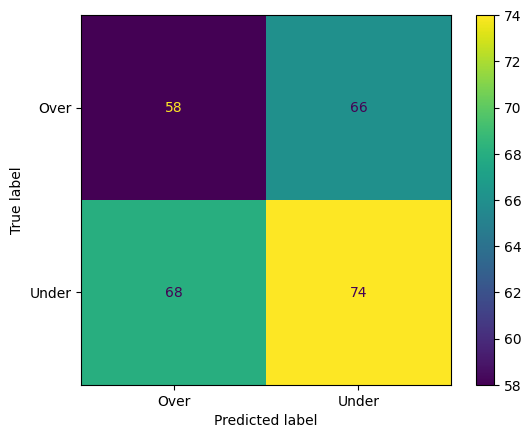

Processing season: 2022
 Week  1: Accuracy: 68.75%
 Week  2: Accuracy: 37.50%
 Week  3: Accuracy: 66.67%
 Week  4: Accuracy: 50.00%
 Week  5: Accuracy: 56.25%
 Week  6: Accuracy: 64.29%
 Week  7: Accuracy: 69.23%
 Week  8: Accuracy: 57.14%
 Week  9: Accuracy: 46.15%
 Week 10: Accuracy: 42.86%
 Week 11: Accuracy: 50.00%
 Week 12: Accuracy: 62.50%
 Week 13: Accuracy: 53.33%
 Week 14: Accuracy: 53.85%
 Week 15: Accuracy: 43.75%
 Week 16: Accuracy: 35.71%
 Week 17: Accuracy: 53.85%
 Week 18: Accuracy: 50.00%
Season 2022: Total accuracy score=53.41%

Classification Report for 2022:
              precision    recall  f1-score   support

        Over       0.48      0.54      0.51       118
       Under       0.59      0.53      0.56       146

    accuracy                           0.53       264
   macro avg       0.53      0.53      0.53       264
weighted avg       0.54      0.53      0.54       264



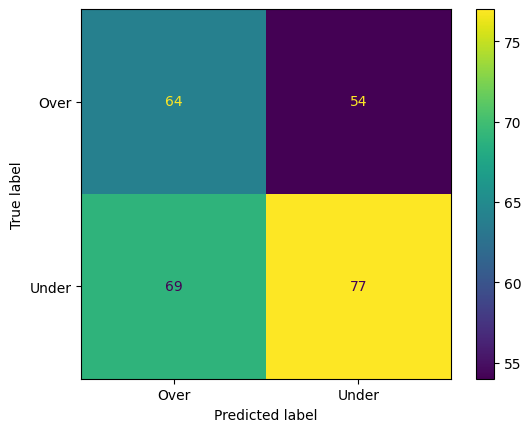

Processing season: 2023
 Week  1: Accuracy: 80.00%
 Week  2: Accuracy: 56.25%
 Week  3: Accuracy: 62.50%
 Week  4: Accuracy: 68.75%
 Week  5: Accuracy: 71.43%
 Week  6: Accuracy: 64.29%
 Week  7: Accuracy: 61.54%
 Week  8: Accuracy: 46.67%
 Week  9: Accuracy: 57.14%
 Week 10: Accuracy: 53.85%
 Week 11: Accuracy: 60.00%
 Week 12: Accuracy: 66.67%
 Week 13: Accuracy: 69.23%
 Week 14: Accuracy: 50.00%
 Week 15: Accuracy: 57.14%
 Week 16: Accuracy: 42.86%
 Week 17: Accuracy: 50.00%
 Week 18: Accuracy: 50.00%
Season 2023: Total accuracy score=59.52%

Classification Report for 2023:
              precision    recall  f1-score   support

        Over       0.55      0.54      0.54       113
       Under       0.63      0.64      0.64       139

    accuracy                           0.60       252
   macro avg       0.59      0.59      0.59       252
weighted avg       0.59      0.60      0.59       252



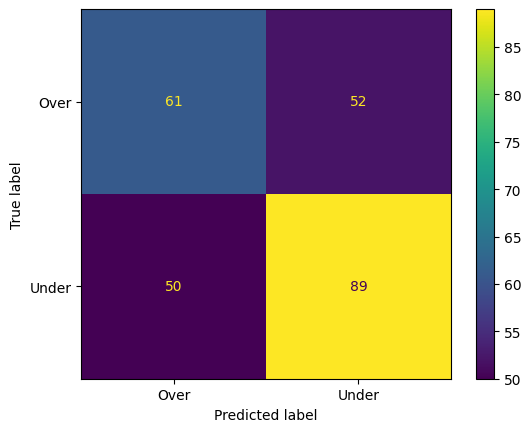

In [52]:
# Set features and target
features = ['Spread', 'Total']
target = 'Under'

# Iterate over 2021 - 2023 seasons for testing with previous seasons
for season in [2021, 2022, 2023]:
    # Display current season
    print(f"Processing season: {season}")
    
    # Initialise the season aggregates
    y_preds = []
    y_trues = []
    
    # Iterate over each week
    for week in range(1, 19):
        # Display current week
        print(f' Week {week:>2}:', end=' ')
        # Create training set(all games before current week(2015-current season))
        train_df = nfl_df.query('Season < @season or (Season == @season and Week < @week) and True_Total != Total')
        
        # Create test set(current week)
        test_df = nfl_df.query('Season == @season and Week == @week and True_Total != Total')
        
        # Create X_train, y_train, X_test, y_test
        X_train = train_df[features]
        y_train = train_df[target]
        X_test = test_df[features]
        y_test = test_df[target]
        
        # Create model
        model = KNeighborsClassifier(n_neighbors=7)
        
        # Create pipeline
        pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
        
        # Train model
        clf = pipeline.fit(X_train, y_train)
        
        # Detect and remove outliers
        pipeline2 = Pipeline([('scaler', StandardScaler()), ('lof', LocalOutlierFactor(novelty=True))])
        pipeline2.fit(X_train)
        # Return the outlier scores (1=inlier, -1=outlier)
        y_test_novelty = pipeline2.predict(X_test)
        # Remove outliers from test set
        mask = [y==1 for y in y_test_novelty]
        X_test = X_test[mask]
        y_test = y_test[mask]
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Override Week 1 Predictions to be Under
        if week == 1:
            y_test = test_df[target]
            y_pred = [1] * len(y_test)
        
        # Get true values
        y_true = y_test
        
        # Display accuracy
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2%}")
        
        # Append predictions and true values
        y_preds.extend(y_pred)
        y_trues.extend(y_true)
        
    # Display the total accuracy score for the current season
    print(f'Season {season}: Total accuracy score={accuracy_score(y_trues, y_preds):.2%}')
    
    # Display the classification report for the current season
    print(f'\nClassification Report for {season}:')
    print(classification_report(y_trues, y_preds, target_names=['Over','Under']))
    
    # Display the confusion matrix for the current season
    cm = confusion_matrix(y_trues, y_preds)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Over','Under'])
    cm_display.plot()
    plt.grid(False)
    plt.show()


In [85]:
# Get and display the neighbors for games in Season 2023, Week 18
# Iterate through the test instances and find their nearest neighbors
index = 0
for game_index, spread, total in X_test.itertuples():
    # Create a single sample for the current game
    current_game = X_test.iloc[[index]][features]
    
    # Scale the data using the pipeline's scaler
    scaled_game = clf['scaler'].transform(current_game)
    
    # Get the neighbor distances and indices using the scaled data
    nbr_distance = clf['model'].kneighbors(scaled_game)[0][0]
    nbr_index = clf['model'].kneighbors(scaled_game)[1][0]
    
    index += 1
    
    print(f'GAME')
    with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
        display(nfl_df.iloc[[game_index],:][['Season','Week','Team','Opp','Spread','Total','True_Total','Under']])
    
    print(f'\nNEAREST NEIGHBORS \ndistances={np.round(nbr_distance, 2).tolist()}')
    with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
        display(nfl_df.iloc[nbr_index,:][['Season','Week','Team','Opp','Spread','Total','True_Total','Under']])
    print('\n')

GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2311,2023,18,Cardinals,Seahawks,3.0,47.5,41,1



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
910,2018,12,Broncos,Steelers,3.0,47.5,41,1
2311,2023,18,Cardinals,Seahawks,3.0,47.5,41,1
2288,2023,16,Vikings,Lions,3.0,47.5,54,0
527,2017,3,Chargers,Chiefs,3.0,47.5,34,1
1459,2020,14,Giants,Cardinals,3.0,47.5,33,1
979,2018,16,Jets,Packers,3.0,47.5,82,0
1515,2021,1,Bengals,Vikings,3.0,47.5,51,0




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2312,2023,18,Ravens,Steelers,3.0,34.5,27,1



NEAREST NEIGHBORS 
distances=[0.0, 0.08, 0.2, 0.2, 0.24, 0.24, 0.28]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2312,2023,18,Ravens,Steelers,3.0,34.5,27,1
2171,2023,8,Giants,Jets,3.5,34.5,23,1
1240,2019,17,Ravens,Steelers,2.0,35.0,38,0
2230,2023,12,Giants,Patriots,4.0,34.0,17,1
2098,2023,3,Jets,Patriots,2.5,35.5,25,1
2175,2023,8,Titans,Falcons,2.5,35.5,51,0
2242,2023,13,Jets,Falcons,2.0,33.5,21,1




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2313,2023,18,Panthers,Buccaneers,4.0,37.0,9,1



NEAREST NEIGHBORS 
distances=[0.0, 0.11, 0.14, 0.2, 0.2, 0.2, 0.2]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2313,2023,18,Panthers,Buccaneers,4.0,37.0,9,1
2280,2023,16,Panthers,Packers,4.0,37.5,63,0
2071,2023,2,Cardinals,Giants,4.5,36.5,59,0
2157,2023,7,Giants,Commanders,3.0,36.5,21,1
906,2018,12,Bills,Jaguars,3.0,36.5,45,0
1233,2019,16,Jets,Steelers,3.0,36.5,26,1
2016,2022,16,Rams,Broncos,3.0,36.5,65,0




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2314,2023,18,Bengals,Browns,-7.5,37.0,45,0



NEAREST NEIGHBORS 
distances=[0.0, 0.11, 0.2, 0.2, 0.2, 0.24, 0.24]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2314,2023,18,Bengals,Browns,-7.5,37.0,45,0
960,2018,15,Jaguars,Commanders,-7.5,36.5,29,1
1754,2021,17,Bears,Giants,-6.5,36.5,32,1
2022,2022,16,49ers,Commanders,-6.5,37.5,57,0
1761,2021,17,Saints,Panthers,-6.5,37.5,28,1
886,2018,10,Jets,Bills,-7.0,38.0,51,0
741,2017,17,Seahawks,Cardinals,-8.0,38.0,50,0




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2315,2023,18,Lions,Vikings,-3.5,46.0,50,0



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
432,2016,14,Chiefs,Raiders,-3.5,46.0,34,1
1167,2019,12,Texans,Colts,-3.5,46.0,37,1
512,2017,2,Chargers,Dolphins,-3.5,46.0,36,1
1049,2019,4,Falcons,Titans,-3.5,46.0,34,1
572,2017,6,Chiefs,Steelers,-3.5,46.0,32,1
1055,2019,4,Packers,Eagles,-3.5,46.0,61,0
67,2015,5,Chargers,Steelers,-3.5,46.0,44,1




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2316,2023,18,Packers,Bears,-3.0,45.0,26,1



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
224,2015,16,Buccaneers,Bears,-3.0,45.0,47,0
2279,2023,16,Falcons,Colts,-3.0,45.0,39,1
86,2015,7,Panthers,Eagles,-3.0,45.0,43,1
1064,2019,5,Bengals,Cardinals,-3.0,45.0,49,0
671,2017,13,Packers,Buccaneers,-3.0,45.0,46,0
95,2015,7,Giants,Cowboys,-3.0,45.0,47,0
889,2018,10,49ers,Giants,-3.0,45.0,50,0




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2317,2023,18,Colts,Texans,1.5,47.5,42,1



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.08, 0.08, 0.08, 0.08, 0.08]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2058,2023,1,Browns,Bengals,1.5,47.5,27,1
2317,2023,18,Colts,Texans,1.5,47.5,42,1
1832,2022,4,Falcons,Browns,1.0,47.5,43,1
1612,2021,7,Dolphins,Falcons,2.0,47.5,58,0
751,2018,1,Colts,Bengals,1.0,47.5,57,0
709,2017,15,Seahawks,Rams,1.0,47.5,49,0
939,2018,14,Browns,Panthers,1.0,47.5,46,1




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2318,2023,18,Raiders,Broncos,-3.0,37.0,41,0



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.08, 0.08, 0.08, 0.11, 0.11]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2318,2023,18,Raiders,Broncos,-3.0,37.0,41,0
2278,2023,15,Titans,Texans,-3.0,37.0,35,1
1053,2019,4,Broncos,Jaguars,-2.5,37.0,50,0
1163,2019,12,Bills,Broncos,-3.5,37.0,23,1
2048,2022,18,Dolphins,Jets,-3.5,37.0,17,1
730,2017,17,Broncos,Chiefs,-3.0,37.5,51,0
2289,2023,16,Jets,Commanders,-3.0,37.5,58,0




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2319,2023,18,Chargers,Chiefs,-3.5,35.5,25,1



NEAREST NEIGHBORS 
distances=[0.0, 0.08, 0.2, 0.23, 0.23, 0.23, 0.23]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2319,2023,18,Chargers,Chiefs,-3.5,35.5,25,1
2023,2022,16,Titans,Texans,-3.0,35.5,33,1
2025,2022,17,Ravens,Steelers,-2.5,35.0,29,1
682,2017,14,Bills,Colts,-3.5,36.5,20,1
2234,2023,12,Titans,Panthers,-3.5,36.5,27,1
2245,2023,13,Buccaneers,Panthers,-3.5,36.5,39,0
2300,2023,17,Broncos,Chargers,-3.5,36.5,25,1




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2320,2023,18,Dolphins,Bills,2.5,48.0,35,1



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.08, 0.08, 0.08, 0.08, 0.08]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
1913,2022,9,Jaguars,Raiders,2.5,48.0,47,1
2320,2023,18,Dolphins,Bills,2.5,48.0,35,1
1488,2020,16,Raiders,Dolphins,3.0,48.0,51,0
1259,2020,1,Panthers,Raiders,3.0,48.0,64,0
829,2018,6,Raiders,Seahawks,3.0,48.0,30,1
1560,2021,4,Falcons,Commanders,2.0,48.0,64,0
289,2016,4,Bears,Lions,3.0,48.0,31,1




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2322,2023,18,Saints,Falcons,-3.0,42.0,65,0



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
515,2017,2,Giants,Lions,-3.0,42.0,34,1
2322,2023,18,Saints,Falcons,-3.0,42.0,65,0
764,2018,2,Cowboys,Giants,-3.0,42.0,33,1
1853,2022,5,Broncos,Colts,-3.0,42.0,21,1
23,2015,2,Chiefs,Broncos,-3.0,42.0,55,0
371,2016,10,Jaguars,Texans,-3.0,42.0,45,0
1137,2019,10,Browns,Bills,-3.0,42.0,35,1




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2323,2023,18,Giants,Eagles,4.5,42.0,37,1



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.08, 0.08, 0.11, 0.11, 0.11]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
427,2016,14,Browns,Bengals,4.5,42.0,33,1
2323,2023,18,Giants,Eagles,4.5,42.0,37,1
693,2017,14,Giants,Cowboys,4.0,42.0,40,1
259,2016,2,Browns,Ravens,4.0,42.0,45,0
1891,2022,7,Commanders,Packers,4.5,41.5,44,0
1616,2021,7,Seahawks,Saints,4.5,42.5,23,1
669,2017,13,Bengals,Steelers,4.5,42.5,43,0




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2325,2023,18,Titans,Jaguars,4.0,41.5,48,0



NEAREST NEIGHBORS 
distances=[0.0, 0.08, 0.08, 0.08, 0.11, 0.11, 0.11]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2325,2023,18,Titans,Jaguars,4.0,41.5,48,0
1891,2022,7,Commanders,Packers,4.5,41.5,44,0
1261,2020,1,Broncos,Titans,3.5,41.5,30,1
2294,2023,16,Titans,Seahawks,3.5,41.5,37,1
89,2015,7,Jaguars,Bills,4.0,41.0,65,0
693,2017,14,Giants,Cowboys,4.0,42.0,40,1
259,2016,2,Browns,Ravens,4.0,42.0,45,0




GAME


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2326,2023,18,Commanders,Cowboys,13.0,46.5,48,0



NEAREST NEIGHBORS 
distances=[0.0, 0.0, 0.11, 0.14, 0.23, 0.24, 0.24]


,Season,Week,Team,Opp,Spread,Total,True_Total,Under
2326,2023,18,Commanders,Cowboys,13.0,46.5,48,0
917,2018,12,Jets,Patriots,13.0,46.5,40,1
1372,2020,8,Giants,Buccaneers,13.0,47.0,48,0
1499,2020,17,Bengals,Ravens,13.5,46.0,41,1
1657,2021,10,Jets,Bills,13.0,47.5,62,0
1762,2021,17,Jets,Buccaneers,13.5,45.5,52,0
1912,2022,9,Texans,Eagles,13.5,45.5,46,0


## Make predictions for Games

In [56]:
# Set the features and the target variable
features = ['Spread','Total']
target = 'Under'

# Set the season and the week
season = 2024
week = 1

# Create training set
train_df = nfl_df.query('Season < @season or (Season == @season and Week < @week)')

# Create X_train and y_train
X_train = train_df[features]
y_train = train_df[target]

# Two-dimensional list with upcoming game data from the home team's perspective
week1 = [
['Ravens @ Chiefs', -3.0, 46.5],
['Packers @ Eagles', -1.5, 48.5],
['Cardinals @ Bills', -7.0, 48.0],
['Panthers @ Saints', -4.5, 40.5],
['Texans @ Colts', +2.0, 48.5]
]

# Create X_new dataframe from the upcoming game data
X_new = pd.DataFrame(week1, columns=['Game','Spread','Total'])

# Set the model
model = KNeighborsClassifier(n_neighbors=7)

# Create pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])

# Fit the classifier
clf = pipeline.fit(X_train, y_train)

# Detect and remove outliers
pipeline2 = Pipeline([('scaler', StandardScaler()), ('lof', LocalOutlierFactor(novelty=True))])
pipeline2.fit(X_train)
# Return the outlier scores (1=inlier, -1=outlier)
y_test_novelty = pipeline2.predict(X_new[features])
# Remove outliers from test set
mask = y_test_novelty == 1
X_new = X_new[mask]

# Make the predictions
y_pred = clf.predict(X_new[features])

# Override Week 1 Predictions to be Under
if week == 1:
    y_pred = [1] * len(X_new)

# Add predictions to the dataframe
X_new['KNC(7)'] = y_pred
X_new['KNC(7)'] = X_new['KNC(7)'].apply(lambda x: 'Under' if x == 1 else 'Over')

# Display the dataframe with the predictions
print(f'MODEL PREDICTIONS FOR WEEK {week} OF THE {season} NFL SEASON\n')
print(X_new[['Game','Spread','Total','KNC(7)']])

MODEL PREDICTIONS FOR WEEK 2 OF THE 2024 NFL SEASON

                Game  Spread  Total KNC(7)
0    Ravens @ Chiefs    -3.0   46.5   Over
1   Packers @ Eagles    -1.5   48.5  Under
2  Cardinals @ Bills    -7.0   48.0   Over
3  Panthers @ Saints    -4.5   40.5  Under
4     Texans @ Colts     2.0   48.5   Over
